(lecture15:measures-of-predictive-accuracy)=
# Measures of Predictive Accuracy


## Training and test datasets

You cannot test how good your model is using the training dataset.
Whatever the metric you use, the performance of your model on the training dataset will always be quite good.
This is because the model is tuned to do well on the training data.
The real question is how well your model does on a dataset it has never see.
This brings us to the concept of a *test dataset*.
How can you make a test dataset?
Well, take whatever data you have and split them into training and test datasets.
For example, you can randomly select 70% of your data and put it in your training set and 30% of the data and put it in your test set.

Let's do this for the motorcyle dataset:

In [32]:
MAKE_BOOK_FIGURES=False

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

def set_book_style():
    plt.style.use('seaborn-v0_8-white') 
    sns.set_style("ticks")
    sns.set_palette("deep")

    mpl.rcParams.update({
        # Font settings
        'font.family': 'serif',  # For academic publishing
        'font.size': 8,  # As requested, 10pt font
        'axes.labelsize': 8,
        'axes.titlesize': 8,
        'xtick.labelsize': 7,  # Slightly smaller for better readability
        'ytick.labelsize': 7,
        'legend.fontsize': 7,
        
        # Line and marker settings for consistency
        'axes.linewidth': 0.5,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'lines.markersize': 4,
        
        # Layout to prevent clipped labels
        'figure.constrained_layout.use': True,
        
        # Default DPI (will override when saving)
        'figure.dpi': 600,
        'savefig.dpi': 600,
        
        # Despine - remove top and right spines
        'axes.spines.top': False,
        'axes.spines.right': False,
        
        # Remove legend frame
        'legend.frameon': False,
        
        # Additional trim settings
        'figure.autolayout': True,  # Alternative to constrained_layout
        'savefig.bbox': 'tight',    # Trim when saving
        'savefig.pad_inches': 0.1   # Small padding to ensure nothing gets cut off
    })

def save_for_book(fig, filename, is_vector=True, **kwargs):
    """
    Save a figure with book-optimized settings.
    
    Parameters:
    -----------
    fig : matplotlib figure
        The figure to save
    filename : str
        Filename without extension
    is_vector : bool
        If True, saves as vector at 1000 dpi. If False, saves as raster at 600 dpi.
    **kwargs : dict
        Additional kwargs to pass to savefig
    """    
    # Set appropriate DPI and format based on figure type
    if is_vector:
        dpi = 1000
        ext = '.pdf'
    else:
        dpi = 600
        ext = '.tif'
    
    # Save the figure with book settings
    fig.savefig(f"{filename}{ext}", dpi=dpi, **kwargs)


def make_full_width_fig():
    return plt.subplots(figsize=(4.7, 2.9), constrained_layout=True)

def make_half_width_fig():
    return plt.subplots(figsize=(2.35, 1.45), constrained_layout=True)

if MAKE_BOOK_FIGURES:
    set_book_style()
make_full_width_fig = make_full_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()
make_half_width_fig = make_half_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()

import numpy as np
import scipy.stats as st

In [33]:
# The url of the motorcycle data:
url = 'https://raw.githubusercontent.com/PurdueMechanicalEngineering/me-239-intro-to-data-science/master/data/motor.dat'
# Download the data
!curl -O $url
# Load the data
data = np.loadtxt('motor.dat')
# The inputs
x = data[:, 0]
# The outputs
y = data[:, 1]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2970  100  2970    0     0  19045      0 --:--:-- --:--:-- --:--:-- 19161


We are going to use the functionality of the Python library [scikitlearn](https://scikit-learn.org/stable/) to split our dataset in to training and test.

In [34]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

Let's plot the training and the test datasets in different colors:

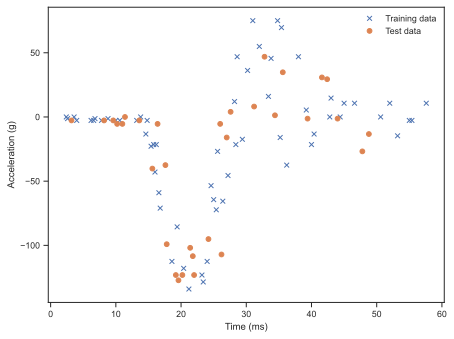

In [35]:
fig, ax = make_full_width_fig()
ax.plot(x_train, y_train, 'x', label='Training data')
ax.plot(x_test, y_test, 'o', label='Test data')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Acceleration (g)')
plt.legend(loc='best')
save_for_book(fig, 'ch15.fig15')

## Fit the model on the training set

Let's repeat here the code that calculates the design matrix for polynomial, Fourier, and radial basis functions:

In [36]:
def get_polynomial_design_matrix(x, degree):
    """Returns the polynomial design matrix of ``degree`` evaluated at ``x``.
    """
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    # Start with an empty list where we are going to put the columns of the matrix
    cols = []
    # Loop over columns and add the polynomial
    for i in range(degree+1):
        cols.append(x ** i)
    return np.hstack(cols)

def get_fourier_design_matrix(x, L, num_terms):
    """Fourier expansion with ``num_terms`` cosines and sines.
    
    Arguments:
    
        L           -       The "length" of the domain.
        num_terms   -       How many Fourier terms do you want. This is not the number
                            of basis functions you get. The number of basis functions
                            is 1 + num_terms / 2. The first one is a constant.
    """
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    N = x.shape[0]
    cols = [np.ones((N, 1))]
    # Loop over columns and add the polynomial
    for i in range(int(num_terms / 2)):
        cols.append(np.cos(2 * (i+1) * np.pi / L * x))
        cols.append(np.sin(2 * (i+1) * np.pi / L * x))
    return np.hstack(cols)
                    
def get_rbf_design_matrix(x, x_centers, ell):
    """Radial basis functions design matrix.
    
    Arguments:
        x          -     the input points on which you want to evaluate the
                         design matrix
        x_center   -     the centers of the radial basis functions
        ell        -     the lengthscale of the radial basis function
    """
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    N = x.shape[0]
    cols = [np.ones((N, 1))]
    # Loop over columns and add the polynomial
    for i in range(x_centers.shape[0]):
        cols.append(np.exp(-(x - x_centers[i]) ** 2 / ell))
    return np.hstack(cols)

Let's fit a polynomial model like before:

In [37]:
degree = 3
Phi_poly_train = get_polynomial_design_matrix(x_train[:, None], degree)
w_poly, _, _, _ = np.linalg.lstsq(Phi_poly_train, y_train, rcond=None)

Because this is a nice 1D problem, you have the luxury of plotting your fitting model and comparing it to the test data.
Here it is:

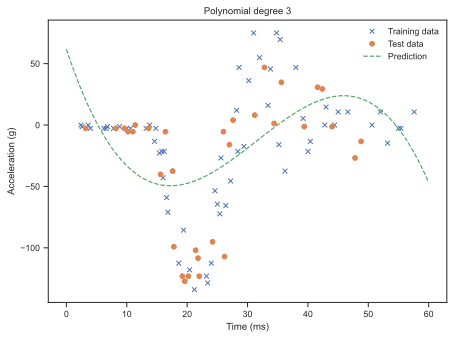

In [38]:
xx = np.linspace(0, 60, 100)
Phi_poly_xx = get_polynomial_design_matrix(xx[:, None], degree)
yy_predict = np.dot(Phi_poly_xx, w_poly)
fig, ax = make_full_width_fig()
ax.set_title('Polynomial degree {0:d}'.format(degree))
ax.plot(x_train, y_train, 'x', label='Training data')
ax.plot(x_test, y_test, 'o', label='Test data')
ax.plot(xx, yy_predict, '--', label='Prediction')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Acceleration (g)')
plt.legend(loc='best')
save_for_book(fig, 'ch15.fig16')

## Test the model with the test set: The predictions-vs-observations plot

As you can imagine, this is not something that you can do if the input has more than two dimensions.
What do you do in that case?
A very nice plot you can do is the predictions-vs-observations plot for the test data.
Here is how it looks:

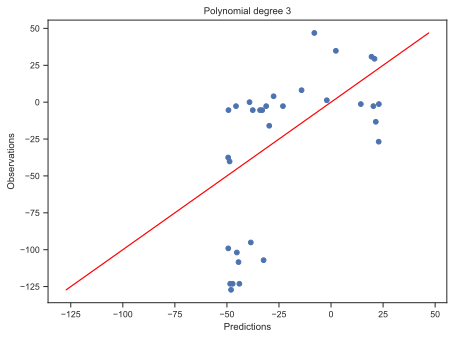

In [39]:
Phi_poly_test = get_polynomial_design_matrix(x_test[:, None], degree)
y_test_predict = np.dot(Phi_poly_test, w_poly)

fig, ax = make_full_width_fig()
ax.set_title('Polynomial degree {0:d}'.format(degree))
ax.plot(y_test_predict, y_test, 'o')
yys = np.linspace(y_test.min(), y_test.max(), 100)
ax.plot(yys, yys, 'r-');
ax.set_xlabel('Predictions')
ax.set_ylabel('Observations')
save_for_book(fig, 'ch15.fig17')

Notice that in this plot I have included a red line that goes through the origin at has a 45 degree angle with the x-axis.
This red line marks the perfect fit, i.e., a perfect agreement between the predictions and the observations.
In other words, the closer the blue dots get to the red line, the better the model.

## The mean squared error

The predictions-vs-observations plot is nice.
But sometimes you just want to characterize your model using a number.
The mean squared error or (MSE) is such a scalar measure of the goodness of fit.
The MSE is the *mean* of the *sum* of the *square* of the *prediction error* over your test data.
If we assume that you have $N_t$ test data points with inputs $x_{t,i}$ and outputs $y_{t,i}$, the the MSE of your model is given by the formula:

$$
\text{MSE} = \frac{\sum_{i=1}^{N_t}\left[y_{t,i} - \mathbf{w}^T\boldsymbol{\phi}(x_{t,i})\right]^2}{N_t}.
$$

In the polynomial model we fitted above, it is:

In [40]:
MSE_poly = np.mean((y_test_predict - y_test) ** 2)
print('MSE_poly = {0:1.2f}'.format(MSE_poly))

MSE_poly = 1961.95


Now, it is obvious that smaller MSE means better model.
But it is a bit hard to understand the absolute meaning of the MSE.
So, some times we look at the relative MSE or (RMSE).
RMSE is the MSE of your model divided by the MSE of the simplest possible model you could make.
Okay. What is the simplest possible model you could make?
It is a constant model.
A model that predicts the same value for the output $y$ no matter what the input $x$ is.
So, mathematically the model is:

$$
y_{\text{simplest}} = c,
$$

for some constant $c$. What is the best such constant?
Well, you can fit it by minimizing the sum of square errors for this simple model.
If you do it, you will get, very intuitively, that the constant should be the empirical average of your training data, i.e.,

$$
y_{\text{simplest}} = \hat{\mu} = \frac{1}{N}\sum_{i=1}^Ny_i.
$$

So, the MSE of this simple model is just:

$$
\text{MSE}_{\text{simplest}} = \frac{\sum_{i=1}^{N_t}\left(y_{t,i} - \hat{\mu}\right)^2}{N_t}.
$$

And we define RMSE to be:

$$
\text{RMSE} = \frac{\text{MSE}}{\text{MSE}_{\text{simplest}}} = \frac{\sum_{i=1}^{N_t}\left[y_{t,i} - \mathbf{w}^T\boldsymbol{\phi}(x_{t,i})\right]^2}{\sum_{i=1}^{N_t}\left(y_{t,i} - \hat{\mu}\right)^2}.
$$

Now, RMSE has an intuitive meaning.
If it is smaller than one, then this means that your model is doing something better than the simplest possible model.
And the smaller it is, the better you do compared to the simplest model.
If the RMSE is greater than one, then your model is really really bad...

```{note}
Sometimes the acronym RMSE is used for the root mean square error which is just the square root of the MSE.
```

Let's find the RMSE for our case:

In [41]:
mu = y_train.mean()
MSE_simplest = np.mean((y_test - mu) ** 2)
print('MSE_simplest = {0:1.2f}'.format(MSE_simplest))
RMSE_poly = MSE_poly / MSE_simplest
print('RMSE_poly = {0:1.2f}'.format(RMSE_poly))

MSE_simplest = 3084.05
RMSE_poly = 0.64


## Coefficient of determination $R^2$

The coefficient of determination is defined by:

$$
R^2 = 1 - \text{RMSE} = 1 - \frac{\sum_{i=1}^{N_t}\left[y_{t,i} - \mathbf{w}^T\boldsymbol{\phi}(x_{t,i})\right]^2}{\sum_{i=1}^{N_t}\left(y_{t,i} - \hat{\mu}\right)^2}.
$$

This measure is telling you how much of the percentage of the variance of the test data is explained by your model.
So, here you want to get as close to one as possible.

Let's see what we get in our case:

In [42]:
R2_poly = 1 - RMSE_poly
print('R2 = {0:1.2f}'.format(R2_poly))

R2 = 0.36


So, in this example our model explains about 35% of the variance of the test data?
What is the rest?
Well, the rest explained by the measurement noise variance...

### Questions

+ Experiment with polynomials of degree 4, 5, 10, 20
+ When are we underfitting?
+ When are we overfitting?
+ Which degree (if any) gives you the best fit?
+ Use the code blocks below to repeat this analysis for the Fourier basis and the radial basis functions. Which choice of the three basis functions seems to be better? Why?

## Example: Repeat the fitting using Fourier features

Below, I train a model on the same dataset but using Fourier features instead of polynomials.
Let's see what we get.

In [43]:
fourier_terms = 20
fourier_L = 60.0
Phi_fourier_train = get_fourier_design_matrix(x_train[:, None], fourier_L, fourier_terms)
w_fourier, _, _, _ = np.linalg.lstsq(Phi_fourier_train, y_train, rcond=None)

The predictions plot:

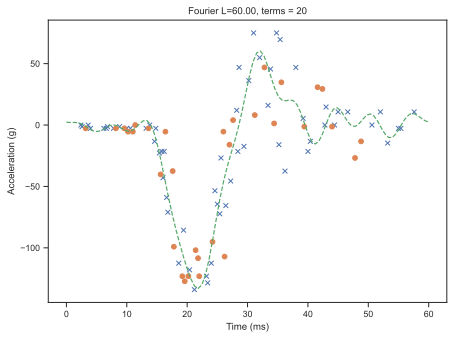

In [44]:
xx = np.linspace(0, 60, 100)
Phi_fourier_xx = get_fourier_design_matrix(xx[:, None], fourier_L, fourier_terms)
yy_predict = np.dot(Phi_fourier_xx, w_fourier)
fig, ax = make_half_width_fig()
ax.set_title('Fourier L={0:1.2f}, terms = {1:d}'.format(fourier_L, fourier_terms))
ax.plot(x_train, y_train, 'x', label='Training data')
ax.plot(x_test, y_test, 'o', label='Test data')
ax.plot(xx, yy_predict, '--', label='Prediction')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Acceleration (g)')
#plt.legend(loc='best')
save_for_book(fig, 'ch15.fig18')

And here is the predictions-vs-observations plot:

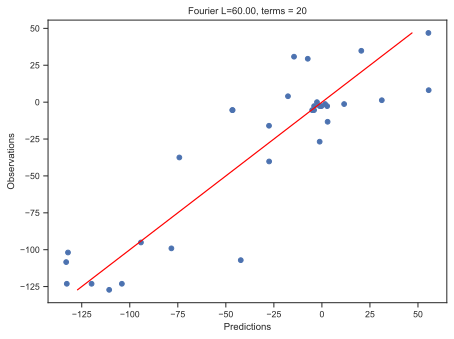

In [45]:
Phi_fourier_test = get_fourier_design_matrix(x_test[:, None], fourier_L, fourier_terms)
y_test_predict = np.dot(Phi_fourier_test, w_fourier)
fig, ax = make_half_width_fig()
ax.set_title('Fourier L={0:1.2f}, terms = {1:d}'.format(fourier_L, fourier_terms))
ax.plot(y_test_predict, y_test, 'o')
yys = np.linspace(y_test.min(), y_test.max(), 100)
ax.plot(yys, yys, 'r-');
ax.set_xlabel('Predictions')
ax.set_ylabel('Observations')
save_for_book(fig, 'ch15.fig19')

And the error metrics we developed:

In [46]:
MSE_fourier = np.mean((y_test_predict - y_test) ** 2)
RMSE_fourier = MSE_fourier / MSE_simplest
R2_fourier = 1 - RMSE_fourier
print('MSE_fourier = {0:1.2f}'.format(MSE_fourier))
print('RMSE_fourier = {0:1.2f}'.format(RMSE_fourier))
print('R2 = {0:1.2f}'.format(R2_fourier))

MSE_fourier = 636.70
RMSE_fourier = 0.21
R2 = 0.79


You see that this model does much much better than the polynomial model by all measures.
In particular, R2 is telling us that 81% of the variance of the test data is explained by our model.

### Questions
+ Modify the code blocks above to use radial basis functions instead of the Fourier basis.